In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import get_nested_attr, count_outliers
from utils.symmetry_scores import get_scores_trace

from transformers import AutoModelForCausalLM

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_scores(d, l, h, dh, model):

    score_List = np.zeros((l,h))

    for i in range(l):
        
        Wq = get_nested_attr(model, f"model.layers[{i}].self_attn.q_proj.weight").T.view(d, h, dh).detach().numpy()
        Wk = get_nested_attr(model, f"model.layers[{i}].self_attn.k_proj.weight").T.view(d, h, dh).detach().numpy()

        for j in range(h):
            
            score_List[i,j] = get_scores_trace(Wq[:,j,:], Wk[:,j,:])

    return  score_List

In [3]:
dir = '../../../_data/fig-symmetry-language-models/Phi-query-key.pkl'

if os.path.isfile(dir):
    with open(dir, 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
'Phi 1 model (tot num parameters 1.3B)'
dh = 64
l = 24
d = 2048
h = d // dh

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1", torch_dtype="auto")
score_List= get_scores(d,l,h,dh,model)
models['Phi-1'] = [l, d, h, dh, score_List]

'Phi 1.5 model (tot num parameters 1.3B)'

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", torch_dtype="auto")
score_List= get_scores(d,l,h,dh,model)
models['Phi-1.5'] = [l, d, h, dh, score_List]

# 'Phi 2 model (tot num parameters 2.7B)'
# dh = 64
# l = 32
# d = 2560
# h = d // dh

# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
# score_List= get_scores(d,l,h,dh,model)
# models['Phi-2.'] = [l, d, h, dh, score_List]


In [5]:
'save'
with open(dir, 'wb') as file:
    pickle.dump(models, file)

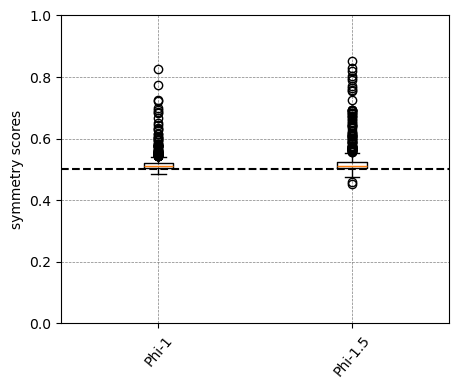

In [4]:
## boxplot visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

plt.boxplot(SList)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('symmetry scores')
plt.xticks(np.arange(1,len(names)+1),names)
plt.xticks(rotation=50)
plt.ylim(0,1)
plt.axhline(y=.5,color='k',linestyle='dashed')

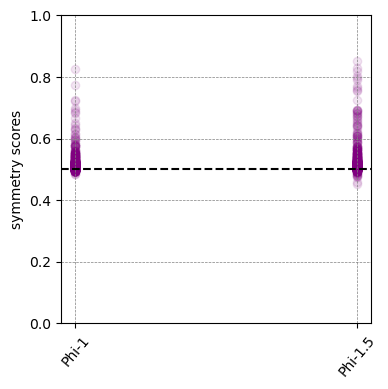

In [30]:
## mean and scatter visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(4,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()).mean(),color='purple')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('symmetry scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=50)
plt.ylim(0,1)
plt.axhline(y=.5,color='k',linestyle='dashed')

(array([0, 1]), [Text(0, 0, 'Phi-1'), Text(1, 0, 'Phi-1.5')])

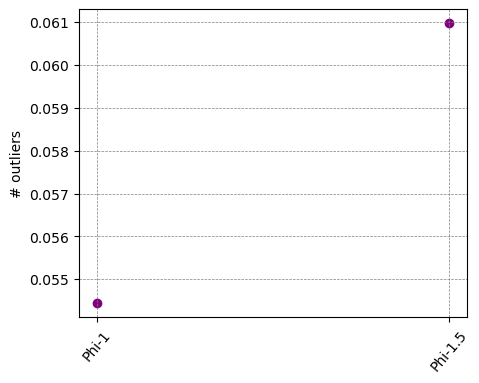

In [34]:
## percentage of outliers visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    outliers = count_outliers(SList[i].flatten())
    plt.scatter(i, outliers.sum() / SList[i].size, color='purple')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('# outliers')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation = 50)

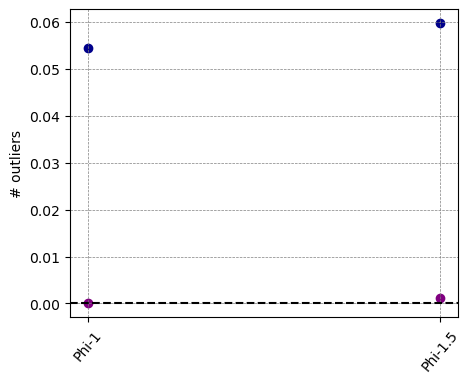

In [36]:
## percentage of outliers visualization

with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

for i, model in enumerate(SList):
    
    outliers = count_outliers(SList[i].flatten())
    plt.scatter(i, outliers[outliers < .5].sum() / SList[i].size, color='purple')
    plt.scatter(i, outliers[outliers > .5].sum() / SList[i].size, color='darkblue')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('# outliers')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation = 50)
plt.axhline(y = .0,color='k',linestyle='dashed')